# From Hardware and infrastructure information to carbon emission when training a deep learning program

---

Master 2 Informatique - Université de Bordeaux
Image et Son  - Image Processing and Computer Vision

---
Authors : Lucia Bouza, Aurélie Bugeau, Anne Vialard
Acknowledgments : Anne-Laure Ligozat

---

## Introduction

This practical session explains how to measure the environmental impacts of deep learning code with the online tool: https://www.green-algorithms.org. The tool requires the entry of various data in order to measure the environmental impact of the executed code. This notebook will explain how to obtain this data.
In this practice, you will measure a part of greenhouse gas emissions (GHG) related to energy consumption from the training of a digit classification network.

<span style="color:DarkRed"> **You will run every command of the following practice both in google collab and on either a computer in cremi or your personal computer. You must answer to questions for both experiments.** </span>

> Remark: If you choose your personal computer, you are in charge of all packages install.

In Cremi, you must start by activating virtual environments in which all packages are installed with the following commands (uncomment them) 

In [1]:
#!source  /net/ens/python/miniconda3/bin/activate
#!source /net/ens/python/miniconda3/bin/activate codecarbon

To launch jupyter remotely:
- log onto machine at cremi, via ssh. 

Then run 
``$jupyter notebook --no-browser --port 1235``


- On your computer:
``$ssh -N -L  1235:localhost:1235 -J jaguar.emi.u-bordeaux.fr user@machine``

## A - Collecting hardware infos

This section will explain how to collect the necessary data for the use of the online tool Green Algorithms. Some of the necessary data is related to the hardware on which the deep learning program is trained. This part explains how to obtain this information depending on the operating system.

> Remark: if you are running on Google Colab's, remember that notebook platform runs on Linux virtual machines.

With green algorithm, the energy consumption is computed as follows:
$$C_{total} = run_{time} \times \rm{PUE} \times \rm{PSF} \times \left(P_{memory}+\sum_{c\in {cores}} P_{c}\times \rm{usage}_c\right) \tag{1}$$
where
- $run_{time}$ is the running time in hours
- $\rm{PUE}$ is the Power Usage Effectiveness. It is an efficiency coefficient of the data center.
- $\rm{PSF}$ is the Pragmatic Scaling Factor. This parameter is used to indicate how many times we have executed the code with the indicated configuration.
- $P_{memory}$ is the power consumed by the memory in Watt.
- $cores$ is the set of all CPU and GPU cores
- $P_{c}$ is the power consumed by core $c$ (CPU or GPU) in Watt.
- $\rm{usage}_c$ is the usage factor of core $c$, between $0$ and $1$.


The *carbon footprint* is calculated according to the following formula:
$$CarbonFootprint = C_{total} \times CI \tag{2}$$
where
- $CI$ is the carbon intensity of the region where the code is being run

In the following, we will explain how all these variables can be estimated. To do so, it is necessary to determine what platform we are running the notebook on. We can be running the code on our local computer, on an on-premises server, or in the cloud. Depending on the platform, we may be sharing resources with other processes, and there may also be other energy consuming elements involved. For example: storage, network devices, air conditioners, etc. If we are running the notebook on Colab, then we are running the code on GCP (Google Cloud Platform). If we are running it on our computer in Jupyter notebook then we are running it locally. There is also the possibility of running the notebook on a server of our educational institution or work. In this case, it is important to ask if the server is in a local datacenter or in the cloud.


### A.1 Cores

> Remark: If you are working in Colab, you can choose to run the code with CPU, GPU or TPU by choosing the option in *Runtime > Change runtime type*.

#### CPU

To know the number of available CPUs and the model on the machine where you are running your program, you can execute the following commands. 

- **Linux**: `cat /proc/cpuinfo` will display information about the available CPUs. To make the information easy to read, we use the following script that determines the number of configured physical and logical CPUs. You can also use `lscpu`.
- **MacOS**: `sysctl -n machdep.cpu.brand_string` will display Chip Brand, Processor Type, Chip Model and CPU Speed. Detailed info on cpu can further be obtained with the command `sysctl -a | grep machdep.cpu`. Other option can be browsing: **System Settings > General > About > Processor.**
- **Windows**: `wmic cpu get name, numberofcores` will display same information as MacOS command. Other option can be browsing: **Task Manager > Performance > CPU.**

<span style="color:DarkRed">Q1. Run the following command and observe the result</span>

In [2]:
!cat /proc/cpuinfo | \
awk -v FS=':' '                                       \
  /^physical id/ { if(nb_cpu<$2)  { nb_cpu=$2 } }     \
  /^cpu cores/   { if(nb_cores<$2){ nb_cores=$2 } }   \
  /^processor/   { if(nb_units<$2){ nb_units=$2 } }   \
  /^model name/  { model=$2 }                         \
                                                      \
  END{                                                \
   nb_cpu=(nb_cpu+1);                                 \
   nb_units=(nb_units+1);                             \
                                                      \
   print "CPU model:",model;                          \
   print nb_cpu,"CPU,",nb_cores,"physical cores per CPU, total",nb_units,"logical CPU units" \
 }'

cat: /proc/cpuinfo: No such file or directory
CPU model: 
1 CPU,  physical cores per CPU, total 1 logical CPU units


<span style="color:Green"> 
Perso:
>sysctl -n machdep.cpu.brand_string
Apple M1
>sysctl -n hw.physicalcpu
8
>sysctl -n hw.logicalcpu
8
    
</span>

<span style="color:Green"> 
Collab:
CPU model:  Intel(R) Xeon(R) CPU @ 2.20GHz
1 CPU,  1 physical cores per CPU, total 2 logical CPU units
</span>

> Remark: In virtual machines the information in the /proc/cpuinfo file may not be correct, and may represent some characteristics of the CPU emulated by the virtualizer. Unfortunately, from the virtual environment there is no way to know exactly the real CPU that is being used for the execution.

#### GPU

Knowing the number and model of GPUs, can be done in the following ways:

- **Linux**: `lshw -C display`
- **MacOS**: browse: **System Settings > General > About > Graphics**
- **Windows**: browse: **Task Manager > Performance > GPU**


> Remark: The virtual machine used by Colab does not have some Linux commands. We know that the GPUs used by Colab are Nvidia, so we can use the nvidia-specific command:`!nvidia-smi -L`. This will show the number of available GPUs and their model and UUID. 

<span style="color:DarkRed">Q2. Run the following command and observe the result</span>

In [3]:
!nvidia-smi -L

zsh:1: command not found: nvidia-smi


<span style="color:Green"> 
    
Perso:
Graphics/Displays:

    Apple M1:

      Chipset Model: Apple M1
      Type: GPU
      Bus: Built-In
      Total Number of Cores: 8
      Vendor: Apple (0x106b)
      Metal Support: Metal 3
      Displays:
        Color LCD:
          Display Type: Built-In Retina LCD
          Resolution: 2560 x 1600 Retina
          Main Display: Yes
          Mirror: Off
          Online: Yes
          Automatically Adjust Brightness: Yes
          Connection Type: Internal
</span>

<span style="color:Green"> 
Collab:
GPU 0: Tesla T4 (UUID: GPU-1ad7a272-2199-8865-c5c2-6f6d650432da)
</span>

#### Computing energy from cores

To compute $P_c$ , Green Algorithms use the Thermal Design Power (**TDP**) of the model of the processing unit provided by the manufacturer. A core power usage is assumed to be equal to the TDP divided by the number of cores (if a chip has 2 cores and a TDP of 50W, then the TDP per core is 25).

TDP is a specification that indicates the maximum amount of power that a computer processor (CPU or GPU) can dissipate when operating at its maximum performance. It refers to the power consumption under the maximum theoretical load.

In general, CPUs with a higher number of cores will have a higher TDP because they require more power to operate at maximum performance. This is because each core in a CPU requires power to perform calculations, and the more cores a CPU has, the more power it will require. However, the relationship between TDP and the number of cores is not always straightforward. Some CPUs may have a lower TDP even though they have more cores, because they are designed to operate at a lower clock speed or have more efficient architecture. Similarly, some CPUs may have a higher TDP even though they have fewer cores, because they are designed to operate at a higher clock speed or have a less efficient architecture.

If the **CPU or GPU model is not listed**,  Green Algorithms uses an average of 12 W per core.

> Remark: Remember that for virtual environments, it is necessary to know the actual CPU, and the percentage of that CPU allocated to the virtual machine. In the event that this value cannot be obtained (as is the case in Colab), take an average value, but keep in mind that the data obtained will not be completely accurate.

<span style="color:DarkRed">Q3. Use http://calculator.green-algorithms.org/ or online documentations of CPU and GPU to find TDP values of your CPU and GPU, compute the value of $\sum_{c\in {cores}} P_{c}\times \rm{usage}_c$ for your  'personal' computer in Watt, considering $\rm{usage}_c=1$ and $\rm{PSF}=1$.</span>

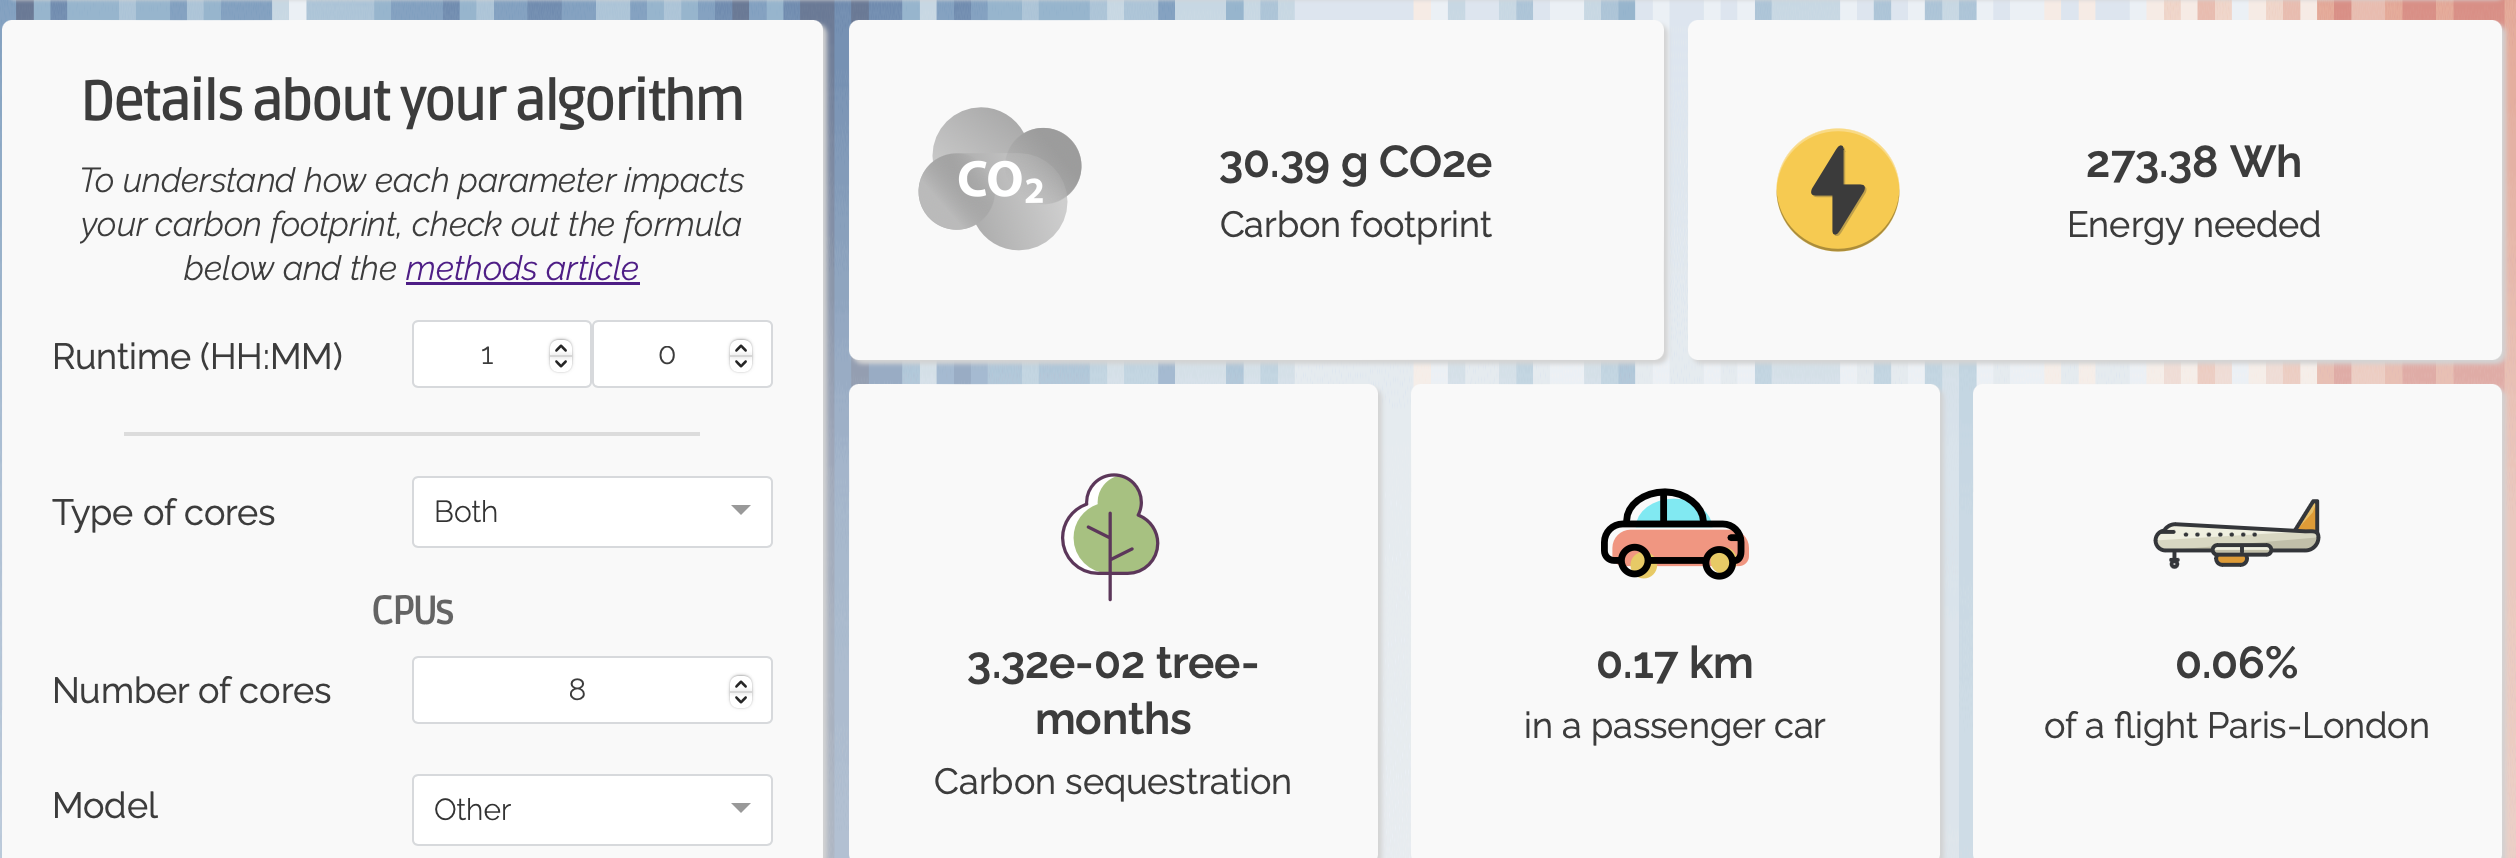

### A.2 Memory

According to  <a name="cite_ref-1"></a>[[1]](#cite_note-1) GPUs are responsible for around 70% of power consumption, CPU for 15%, and RAM for 10%.
Some tools like Green-Algorithms consider that power consumption of RAM depends strongly on the available memory, independently of the memory consumed.

We can check the amount of available memory available for the GPU using the following commands:

- **Linux**: `grep MemTotal /proc/meminfo`. The command returns the value in KB. It will be necessary to convert it to GB to use the tool (1 GB = 1024 MB = 1048576 KB). Another command is `free -h --si | awk  '/Mem:/{print $2}'`
- **MacOS**: `system_profiler SPHardwareDataType | grep "Memory:"`. Other option  can be browsing: **System Settings > General > About > Memory.**
- **Windows**: `systeminfo | findstr /C:"Total Physical Memory"`. The command returns the value in MB, it will be necessary to convert it to GB to use the tool. Other option  can be browsing: **Task Manager > Performance > Memory**


Green Algorithms, considers a consumption of 0.3725 W per GB of memory available (if we have all the server memory available, it will account for all the server memory. If we are in an HPC cluster, it will account only for the amount of memory requested, regardless of how much the process consumes). The value 0.3725 was obtained experimentally <a name="cite_ref-2"></a>[[2]](#cite_note-2).

<span style="color:DarkRed">Q4. Run the following command and observe the result. Using Green Algorithm, verify the value of $P_{memory}$</span>

In [4]:
!free -h --si | awk  '/Mem:/{print $2}'

zsh:1: command not found: free


<span style="color:Green"> 
Perso:
0.3725*8.= 2.98
</span>

<span style="color:Green"> 
Collab:
    
0.3725*12= 4.47
</span>

### A.3 Run time  and usage factor $usage_c$

The *run time* (or real time) refers to the duration of execution of the process, like using a stop watch.

The *process time* is the amount of time during which a core (CPU, GPU or TPU) is used for processing instructions of a computer program. The total process time is the combination of the amount of time the cores spent performing some action for a program and the amount of time they spent performing system calls for the kernel on the program's behalf. <a name="cite_ref-3"></a>[[3]](#cite_note-3).
$$ process_{time} = user_{time} + system_{time} $$

The cores usage factor is then the percentage of all available cores the job got, calculated as:
$$ usage_{c} = \frac{process_{time}}{(run_{time} * number_{cores})} $$

We can measure the process time of the CPUs and the real time spent by the code with the `time` command (on Linux and MacOS). Unfortunately there is no similar command for Windows. It will be necessary to use language-specific libraries as `psutil` for Python. We will see an example below to use both methods.

---
Remark: If your CPU has more logical cores than physical cores, it uses hyperthreading: the hardware components of one physical core are shared between several threads. Each thread has at least its own set of registers. Most resources of the core (arithmetic and logic unit, floating point unit, cache) are shared between the threads. When hyperthreading is enabled, there are as many architectural state, including registers, per core as threads. These registers become visible to the operating system, which doubles the physical CPU capacity: for each core, one could theoretically reach 200% utilization according to standard monitoring tools, such as top. However, given the resources that are shared, this capacity cannot be achieved in practice, so in reality 200% is not the maximum real capacity. According to [intel]( https://www.intel.com/content/www/us/en/developer/articles/tool/performance-counter-monitor.html#cpu_utilization), the maximum capacity is up to 130%. (30% more than without hyperthreading). Measuring usage factor with hyperthreading is therefore not direct. 

*In CREMI, we will assume that "number_cores' in previous formula is 30% more than the number of physical cores available.*

*If you are running on you own computer with superuser privileges, you can run the following script to turn off hyper-threading (note that you might need to adapt the script for your environment)*

<code>
#!/bin/bash

for cpunum in $(cat /sys/devices/system/cpu/cpu*/topology/thread_siblings_list | cut -s -d, -f2- | tr ',' '\n' | sort -un)
do
    echo 0 > /sys/devices/system/cpu/cpu$cpunum/online
done
</code>
---

<span style="color:DarkRed">Q5. Give some cases where Real time may be greater than processing time, and vice versa.</span>

<span style="color:Green"> 
Real time exceeds processing time: Often due to I/O waits, context switching, concurrency overload, or external delays.
Processing time exceeds real time: This can happen with CPU-bound tasks, high resource usage, measurement inaccuracies, or single-core systems.
    
</span>

#### Measuring real time and CPU time when training a network

To run experiments, you will use the code in `TrainingClassification.py`.

<span style="color:DarkRed">Q6. Briefly explain the architecture of the network.</span>

After the model is defined, before moving on to training, a few more things need to be configured, which are added during the compile step:
-    loss function: error function to minimize. We usually refer to it as loss
-    optimizer: algorithm used to optimize the function. Essentially, which gradient descent algorithm to use. It must be an object from the optimizers module, instantiated with the desired parameters, or a string indicating which one to use, in which case the default values are used.
-    metrics: metrics to be used to monitor the evolution of the training.
We use as optimizer an instance of SGD, with a learning rate lr=0.01, crossentropy loss and accuracy metric.

they are in input a picture of 28*28 of numbers; the hidden layers have 32 neurons and the output layer have 10 categorical.
the loss is CrossEntropyLoss.
they are no functionnal activation.

The training is done in 5 epochs and normally takes less than a minute on different infrastructures. This experiment runs on a single GPU if any.
To get the process time used by the script, it is possible to use the command  `time`. The total time spent by the script corresponds with the real value (run time). The CPU time will be the sum of the user and sys values.

In [5]:
!time python3 TrainingClassification.py

zsh:1: command not found: python
python TrainingClassification.py  0,00s user 0,00s system 63% cpu 0,002 total


<span style="color:Green"> 
Perso:
python3 TrainingClassification.py  14,67s user 3,92s system 119% cpu 15,527 total

Collab:
real	0m53.048s
user	0m50.460s
sys	0m0.985s
</span>

It is also possible to use the libraries `psutil` and `time` to measure the time used by the script, and to obtain the process time. An example is provided in `TrainingClassification_withtime.py`. The total time spent by the script corresponds to the real value. The CPU time will be the sum of the user and sys values.

In [10]:
!python3 TrainingClassification_withtime.py

Traceback (most recent call last):
  File "/Users/gabrielmariebrisson/Documents/master/semestre_3/Ecologie/TP1/TP1/TrainingClassification_withtime.py", line 9, in <module>
    import torch
ModuleNotFoundError: No module named 'torch'


<span style="color:Green"> 

Perso:
------------------------------------------------------
DATE INIT:  2024-09-12T16:46:36

sh: nvidia-smi: command not found
Epoch [1/5], Train Loss: 1.9512, Train Acc: 0.5178, Val Loss: 1.4728, Val Acc: 0.6762
sh: nvidia-smi: command not found
Epoch [2/5], Train Loss: 1.1554, Train Acc: 0.7407, Val Loss: 0.9013, Val Acc: 0.8034
sh: nvidia-smi: command not found
Epoch [3/5], Train Loss: 0.7847, Train Acc: 0.8245, Val Loss: 0.6633, Val Acc: 0.8558
sh: nvidia-smi: command not found
Epoch [4/5], Train Loss: 0.6134, Train Acc: 0.8609, Val Loss: 0.5396, Val Acc: 0.8787
sh: nvidia-smi: command not found
Epoch [5/5], Train Loss: 0.5179, Train Acc: 0.8767, Val Loss: 0.4669, Val Acc: 0.8901
------------------------------------------------------
DATE END:  2024-09-12T16:46:50

------------------------------------------------------
Real Time: 14.0945 seconds
User Time: 23.2100 seconds
System Time: 21.0300 seconds
</span>

<span style="color:Green"> 

Collab:
------------------------------------------------------
DATE INIT:  2024-09-12T15:17:02

Epoch [1/5], Train Loss: 1.9716, Train Acc: 0.5264, Val Loss: 1.5086, Val Acc: 0.7065
Epoch [2/5], Train Loss: 1.1613, Train Acc: 0.7678, Val Loss: 0.8848, Val Acc: 0.8240
Epoch [3/5], Train Loss: 0.7599, Train Acc: 0.8393, Val Loss: 0.6369, Val Acc: 0.8622
Epoch [4/5], Train Loss: 0.5879, Train Acc: 0.8670, Val Loss: 0.5179, Val Acc: 0.8809
Epoch [5/5], Train Loss: 0.4980, Train Acc: 0.8812, Val Loss: 0.4501, Val Acc: 0.8918
------------------------------------------------------
DATE END:  2024-09-12T15:17:52

------------------------------------------------------
Real Time: 50.0720 seconds
User Time: 55.6100 seconds
System Time: 5.0400 seconds
    
</span>

<span style="color:DarkRed">Q7. Do you observe some differences? <br> What is CPU approximate usage factors when running `TrainingClassification.py` ? You can use command htop while running to observe usage of logical cores. 
  </span>

<span style="color:Green"> 

Yes, there are differences between the real time and CPU times reported.

Real Time:  14.0945 seconds
User Time: 23.2100 seconds.
System Time: 21.0300 seconds.

The CPU time is the sum of user and system times, totaling 44.2400 seconds, which is significantly higher than the real time of 14.0945 seconds. This indicates that there may be some parallelism in your execution, or the CPU is spending time waiting for other operations.</span>

#### Measuring GPU time when training a network

Unfortunately, there is no tool that can be used with the command line that gives us the total time of the script (whole time), the CPU time and the GPU time, in order to calculate the CPU and GPU usage factor required by Green-Algorithms.  



> To measure the process time of GPUs, you may use the tool [NVIDIA Nsight Compute](https://developer.nvidia.com/nsight-compute) , when available. You need to add the time of all the child processes that are using the GPU. To make the task easier, we can send the data to a CSV file and perform the sum there.
`!ncu --csv --metrics gpu__time_active  --target-processes all python TrainingClassification.py >> gpu.csv`
>
>[NVIDIA Nsight Compute](https://developer.nvidia.com/nsight-compute) can be used to measure GPU time, but requires the `libnvfuser_codgen.so` library, which is not present in Colab.

Another option, used here, is to take empirical and specific measurements of the use of the GPU during the execution of their algorithm using the `nvidia-smi` tool, and extrapolate that value of GPU utilization to the entire execution. It is important to note that this utilization percentage corresponds to the total utilization, and not just the utilization of the process. There could be other processes running on the available GPUs. 
The python script `TrainingClassification_withtime.py` has a call to `nvidia-smi` in each epoch, leaving it's output in the file `nvidiaFile`.

Up to our knowledge, there is also no tool that measures GPU time or GPU utilization for *non-Nvidia GPUs*.


<span style="color:DarkRed">Q8. Observe the output file `nvidiaFile`. What is the mean  GPU utilization? How many processes are running on the GPU? </span>

<span style="color:Green"> 

the mean is 4.3 .10 processes are running.

(5+5+4+4+3+5+4+5+5+3)/10=4.3</span>

## B. Practice with Green Algorithms

<span style="color:DarkRed">Q9. Using http://calculator.green-algorithms.org/, compute energy consumption for the program `TrainingClassification.py` when run in cremi/personal computer and Google Colab. For this question, consider you are running in France, with $PUE=1$ and $\rm{PSF}=1$, and usage factors obtained previously. What do you think of the result?</span>

<span style="color:DarkRed">Q10. Use Green Algorithms to estimate energy consumption and carbon footprint of the following _scenario 1_, with $PUE=1$ and $\rm{PSF}=1$. What do you think of the result? </span>
|  Specifications |   | 
|---|---|
| Execution time | 190h |   
| Number of CPUs  |  4 |   
| Type of CPUs  | Xeon E5-2683 v4  |  
| Number of GPUs  | 4  | 
| Type of GPUs  |  Tesla V100 |  
| Available memory |  32 Go |   
| Location of the server | Orsay,France  |  

<span style="color:Green"> 
Q9. Perso: 1.37 Wh
    Collab: 2.17 Wh
I think for the small program, it's more cost-effective to use one's personal computer.
<br>
Q10. 235.96 kWh and 26.23 kg CO2e
It's a lot of energy. I hope it's a good program.</span>


## C. Other information on training and infrastructure information

### C.1 Power Usage Efficiency (PUE)

PUE is the efficiency coefficient of the data center. If PUE is not given, Green Algorithms considers the world average value given in 2019 for servers: 1.67, but we recommend considering the 2022 average value: 1.55 <a name="cite_ref-4"></a>[[4]](#cite_note-4).

For personal computers we generally consider PUE=1, as there are no other important devices consuming power.

<span style="color:DarkRed">Q11. Recall what is PUE.
An important part of the non-IT consumption of a datacenter comes from air conditioning. What do you think about the relevance of using an average PUE?</span>

In the following we will consider a PUE of 1 for personal computer, 1.1 for Google Collab and 1.2 for datacenter in Orsay. 

<span style="color:DarkRed">Q12. What are the energy consumption obtained with Green Algorithms with these PUE values ?</span>

<span style="color:Green"> 
Q.11<br>
"Power usage effectiveness (PUE) is a metric used to determine the energy efficiency of a data center. PUE is determined by dividing the total amount of power entering a data center by the power used to run the IT equipment within it."
www.techtarget.com
The average PUE allows data center managers to quickly and easily assess energy efficiency. However, this average must be accompanied by the specific values of the efficiency-oriented centers, in order to set clear and measurable objectives for continuous improvement.
<br>
Q.12 <br>
1.2 for datacenter in Orsay: 283.16 kWh
1.1 for Google Collab: (impossible to choose the PUE) 28.06 kWh
1 for personal computer: (impossible to choose the PUE) 51.94 kWh </span>

<span style="color:DarkRed">Q13. For Google datacenters, the PUE is 1.1 <a name="cite_ref-5"></a>[[5]](#cite_note-5). Explain why this value is lower in Google  datacenters? Do you think this means every deep learning project should be run in Google datacenters? </span>

<span style="color:Green"> I think it depends on the goal. If you want to minimize CO2 emissions, it is best to use your personal computer, because the PUE is close to 1, which means that there is virtually no loss of energy due to cooling systems or infrastructure. On the other hand, if you are looking for speed and higher computing power, it is better to use Google's data centers. Their systems are optimized to run intensive deep learning tasks thanks to specially designed infrastructures </span>

The following image was taken from  <a name="cite_ref-6"></a>[[6]](#cite_note-6).

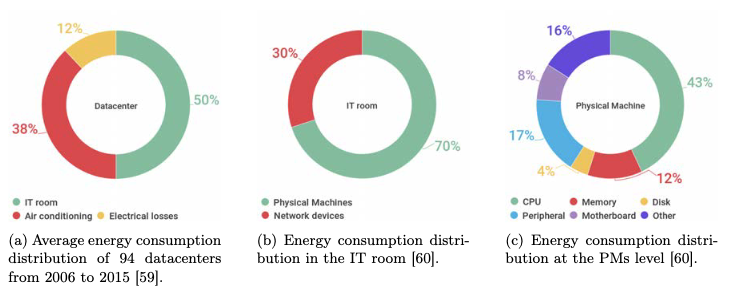

In [7]:
from IPython.display import Image
Image(filename='Guyon.png') 

JKJ — Aujourd’hui à 13:15
<span style="color:DarkRed">Q14. What is the value of PUE is this figure?</span>
<br>
<span style="color:Green"> PUE = Total d'energie consummé par le datacenter / Energie consummé par l'équipement IT (IT room) <br>
PUE = 100% / 50%<br>
PUE = 2<br> </span>
<span style="color:DarkRed">Q15. Assuming that the data center's electricity consumption follows this distribution, what proportion of the electricity consumption of the IT room can be studied with Green Algorithms? Note that is this figure, only CPUs are considered, so it is not fully applicable to our case of study.</span>

<span style="color:Green">
<br> On affecterait que 70% de l'IT room au sein duquel on affecterait que  43% <br>
Donc :  0,43 * (0,7 * (0,5)) = 0,1505 du total donc on affecterait que 15,05 % du total du datacenter <br> </span>

<span style="color:DarkRed">Q16. Assuming CPU and GPU are part of the 43% in figure (c), what would be the complete energy consumption of the IT room when training digit classification code in Google Collab and scenario 1 ? </span>
<span style="color:Green">
<br>
70% * (100% / 43%) = 162.79%
La consommation de la IT room aurait de 162,79% d'une des machines actuelles </span>

### C.2 Pragmatic Scaling Factor

This parameter is used to indicate how many times we have executed the code with the indicated configuration.

<span style="color:DarkRed">Q17. What is the pragmatic scaling factor until now for this practice?
What is approximately the pragmatic scaling factor for the latest deep learning project you have conducting during your studies?</span>

<span style="color:Green"> On a lancé 2 fois l'algo donc c'est 2 , sur le dernier projet le Pragmatic Scalling factor devait au moins être de 50 c'était notre premier gros projet. </span>

### C.3 Location

Carbon footprint is affected by the location from where the code is being executed. The origin of the energy used is key when determining greenhouse emissions. If we are running in the cloud, and the provider has several datacenters around the planet, it is sometimes possible to choose where you want to run the code from.

We can check the execution location with the command:
- **Linux, Windows and MacOS**: `curl ipinfo.io`

> **Remark:** In the case of Colab, you cannot choose where to execute the codes. Nevertheless, you can also use previous command and then determine the datacenter where the code is executed with the following [link](https://cloud.google.com/about/locations?hl=es). We do not know in advance in which datacenter the virtual machine where the notebook will run will be created. It is necessary to execute the command every time we create or reset the runtime, since the location may change.

<span style="color:DarkRed">Q18. Run the following command and observe the result. What is the value of carbon intensity $CI$ used by Green Algorithm at the location where your code is running, according to [Green Algorithm](http://calculator.green-algorithms.org/)?</span>

<span style="color:Green">  France : 17,73 mg CO2e pour 3.46e-01 Wh<br> </span>

In [8]:
!curl ipinfo.io

^C


> Remark: note that from this information on Google Colab, PUE could be updated with values taken from [5].

<span style="color:DarkRed">Q19. How do you think the emissions evolve with the country? Verify your hypotheses on Green Algorithm (for Sweden or Poland for instance). </span>


Carbon intensity varies according to location but also to other variables, such as the time of day of execution, or the distribution of energy sources at a given moment.  It is important to mention that Green Algorithms does not yet take the information of carbon intensity in real time. The carbon intensity data is taken from [this file](https://github.com/GreenAlgorithms/green-algorithms-tool/blob/master/data/latest/CI_aggregated.csv), where for each country or region the source of information is specified. These values are an average.

As additional information, carbon emissions of many countries can be checked in real time on the site https://app.electricitymaps.com/.

<span style="color:Green"> L'émission de Carbon évolue selon le pays dans lequel on est pour plusieurs raisons : <br>
 La production d'électricité est plus ou moins carbonée selon les pays (nucléaire, renouvelable, charbon, gaz, pétrole)<br>
 L'électricité est plus ou moins carbonné au seins d'un même pays selon les moments de la journé <br> 
<br> 
1exécution du premier prog : <br> 
 France : 17,73 mg  CO2e <br> 
 Sweden : 1,96 mg CO2e <br> 
 Poland : 262,64 mg CO2e <br> </span>

<span style="color:DarkRed">Q20. Compare the value of $CI$ you have just found with the one in real time from electrictymaps? What do you observe? Also compare with the last 24 hours and 30 days?</span>

<span style="color:Green"> 
Sur electricity map : 23 g = 23 000 mg /kWh <br>
On a : 17,73 mg pour 0.346 Wh = 0.000346 kWh <br>
17,73 / 0.000346 ≈ 51 292.51 mg /kwH  <br>

Selon  green-algorithms.org on consommerait 2 fois plus que ce que dirait electricity map pour cette consomation électrique, mais on part avec des toutes petites valeurs ce qui peut rendre le calcul imprécis </span>

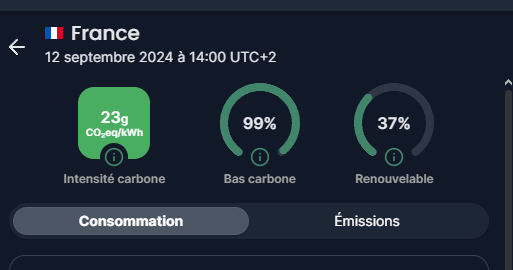

<span style="color:DarkRed">Q21.According to a Google research article  <a name="cite_ref-7"></a>[[7]](#cite_note-7), Google's renewable energy purchases reduce the impact to zero (if running codes on Google servers). What do you think? </span>

<span style="color:Green"> Peut-être que Google arrive à nulifié son impact environnemental en investissant dans des actions environnenementales  mais il est important de noter que cela ne signifie pas nécessairement que l'impact environnemental de chaque opération individuelle est nul </span>

## References


<a name="cite_note-1"></a>[1] [^](#cite_ref-1) M.Hodak,M.Gorkovenko,and A.Dholakia,“Towards power efficiency in deep learning on data center hardware,” 2019 IEEE International Conference on Big Data (Big Data), pp. 1814–1820, 2019.

<a name="cite_note-2"></a>[2] [^](#cite_ref-2) https://www.tomshardware.com/reviews/intel-core-i7-5960x-haswell-e-cpu,3918-13.html

<a name="cite_note-3"></a>[3] [^](#cite_ref-3) Wikipedia: https://en.wikipedia.org/wiki/Time_(Unix)

<a name="cite_note-4"></a>[4] [^](#cite_ref-4) Uptime Institute (https://uptimeinstitute.com/uptime_assets/6768eca6a75d792c8eeede827d76de0d0380dee6b5ced20fde45787dd3688bfe-2022-data-center-industry-survey-en.pdf)

<a name="cite_note-5"></a>[5] [^](#cite_ref-5) https://www.google.com/about/datacenters/efficiency/

<a name="cite_note-6"></a>[6] [^](#cite_ref-6) David Guyon. Supporting energy-awareness for cloud users. Networking and Internet Architecture, Université Rennes 1, 2018

<a name="cite_note-7"></a>[7] [^](#cite_ref-7)Patterson et al., The Carbon Footprint of Machine Learning Training Will Plateau, Then Shrink, arXiv:2204.05149, 2022 


